# Optical Character Recognition


## Loading the dataset with Keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

print('Train data: {} Train labels: {}'.format(train_x.shape, train_y.shape))
print('Test data:  {} Test labels:  {}'.format(test_x.shape, test_y.shape))

11493376/11490434 [==============================] - 0s 0us/step
Train data: (60000, 28, 28) Train labels: (60000,)
Test data:  (10000, 28, 28) Test labels:  (10000,)


##Data analysis

Looking at the number of samples in the train and test data.

In [ ]:
num_train_rows = train_x.shape[0]
num_test_rows = test_x.shape[0]

print('There are {} train samples'.format(num_train_rows))
print('There are {} test samples'.format(num_test_rows))

There are 60000 train samples
There are 10000 test samples


Checking how balanced the dataset is, by counting all of the different digits.


In [ ]:
import numpy as np

print(np.unique(train_y, return_counts=True)[1])

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


All of the digits have around 6000 samples, the dataset is balanced.

## Preprocessing

The grayscale is in the range 0 to 255. With normalization it is transformed to the range 0.0 to 1.0. \\
Normalization: divinding each pixel with the max value (the max value is 255, because this is the maximum value of the grayscale).

In [ ]:
print('Train min: {}'.format(np.min(train_x)))
print('Test min:  {}'.format(np.min(test_x)))
print('Train max: {}'.format(np.max(train_x)))
print('Test max:  {}'.format(np.max(test_x)))

max_value = 255
train_x_normalized = train_x.astype('float32') / max_value
test_x_normalized = test_x.astype('float32') / max_value

print('Train normalized min: {}'.format(np.min(train_x_normalized)))
print('Test normalized min:  {}'.format(np.min(test_x_normalized)))
print('Train normalized max: {}'.format(np.max(train_x_normalized)))
print('Test normalized max:  {}'.format(np.max(test_x_normalized)))

Train min: 0
Test min:  0
Train max: 255
Test max:  255
Train normalized min: 0.0
Test normalized min:  0.0
Train normalized max: 1.0
Test normalized max:  1.0


The images have 1 color channel; thus reshaping the images to 28x28x1 shape

In [ ]:
x_train = np.expand_dims(train_x_normalized, -1)
x_test = np.expand_dims(test_x_normalized, -1)
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


Converting the labels into categorical. There are 10 digits thus there are 10 classes.

In [ ]:
from keras.utils import np_utils

num_classes=10
y_train = np_utils.to_categorical(y=train_y, num_classes=num_classes)
y_test = np_utils.to_categorical(y=test_y, num_classes=num_classes)

## Training

### Define functions

In [ ]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import RMSprop, SGD, Adam
from keras.losses import CategoricalCrossentropy

In [ ]:
from sklearn.model_selection import KFold

def cross_validation(create_model, x_data, y_data, n_folds=5, batch_size=128, num_of_epochs=10, verbose=0):
  scores = []
  histories = []
  accuracy_array = []
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  
  for train_index, test_index in kfold.split(x_data):
    train_x = x_data[train_index]
    train_y = y_data[train_index]
    test_x = x_data[test_index]
    test_y = y_data[test_index]

    model = create_model()
		
    history = model.fit(train_x, train_y, epochs=num_of_epochs, batch_size=batch_size, validation_data=(test_x, test_y), verbose=verbose)
    
    _, accuracy = model.evaluate(test_x, test_y, verbose=verbose)
    print('Accuracy: {}'.format(accuracy * 100))
    accuracy_array.append(accuracy)

    histories.append(history)
  return histories, accuracy_array

print('Defined cross_validation function')

Defined cross_validation function


In [ ]:
def compare_models(create_models_array, x_data, y_data, n_folds=5, batch_size=128, num_of_epochs=10, verbose=0):
  model_histories = []
  model_accuracies = []

  for create_model in create_models_array:
    histories, accuracy_array = cross_validation(create_model, x_data, y_data, n_folds=n_folds, batch_size=batch_size, num_of_epochs=num_of_epochs, verbose=verbose)
    
    model_histories.append(histories)
    model_accuracies.append(accuracy_array)
  
  return model_histories, model_accuracies

print('Defined compare_models function')

Defined compare_models function


In [ ]:
from sklearn.model_selection import KFold

def evaluate_final_models(create_models, train_x, train_y, test_x, test_y, n_folds=5, batch_size=128, num_of_epochs=10, verbose=0):
  histories = []
  accuracy_array = []
  
  for create_model in create_models:
    model = create_model()
		
    history = model.fit(train_x, train_y, epochs=num_of_epochs, batch_size=batch_size, validation_data=(test_x, test_y), verbose=verbose)
    
    _, accuracy = model.evaluate(test_x, test_y, verbose=verbose)
    print('Accuracy: {}'.format(accuracy * 100))
    accuracy_array.append(accuracy)

    histories.append(history)
  return histories, accuracy_array

print('Defined evaluate_final_models function')

Defined evaluate_final_models function


In [ ]:
import matplotlib.pyplot as plt

# plot diagnostic learning curves
def show_plots(histories, index, name):
  plt.rcParams['figure.figsize'] = (10,10)
  for i in range(len(histories)):
    plt.title('Model{} Loss'.format(index))
    plt.plot(histories[i].history['loss'], color='blue', label='train' if i == 0 else '')
    plt.plot(histories[i].history['val_loss'], color='red', label='test' if i == 0 else '')
    plt.xlabel('Epochs'),
    plt.ylabel('Loss'),
    plt.legend(loc='best')
    plt.tight_layout()
  plt.savefig('drive/MyDrive/university/machine_learning/optical_character_recognition/{}-loss{}.svg'.format(name, index), format='svg')
  plt.show()

  for i in range(len(histories)):
    plt.title('Model{} Accuracy'.format(index))
    plt.plot(histories[i].history['accuracy'], color='blue', label='train' if i == 0 else '')
    plt.plot(histories[i].history['val_accuracy'], color='red', label='test' if i == 0 else '')
    plt.xlabel('Epochs'),
    plt.ylabel('Accuracy Score'),
    plt.legend(loc='best')
    plt.tight_layout()
  plt.savefig('drive/MyDrive/university/machine_learning/optical_character_recognition/{}-accuracy{}.svg'.format(name, index), format='svg')
  plt.show()


print('Defined show_plots function')

Defined show_plots function


### Creating models

In [ ]:
def create_model_1a():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_1a function')

Defined create_model_1a function


In [ ]:
def create_model_1b():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dense(100, activation='relu'),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_1b function')

Defined create_model_1b function


In [ ]:
def create_model_1c():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dropout(0.5),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_1c function')

Defined create_model_1c function


In [ ]:
def create_model_2a():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_2a function')

Defined create_model_2a function


In [ ]:
def create_model_2b():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dense(100, activation='relu'),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_2b function')

Defined create_model_2b function


In [ ]:
def create_model_2c():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dropout(0.5),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_2c function')

Defined create_model_2c function


In [ ]:
def create_model_3a():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_3a function')

Defined create_model_3a function


In [ ]:
def create_model_3b():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dense(100, activation='relu'),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_3b function')

Defined create_model_3b function


In [ ]:
def create_model_3c():
  model = Sequential(
      [
      Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      Conv2D(64, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dropout(0.5),
      Dense(num_classes, activation="softmax"),
    ]
  )

  optimizer = Adam()
  loss = CategoricalCrossentropy()
  metrics = ['accuracy']

  model.compile(optimizer, loss, metrics)
  
  return model

print('Defined create_model_3c function')

Defined create_model_3c function


### Model comparisons

Creating an array containing the models.

In [ ]:
create_models_array = [
 create_model_1a,
 create_model_1b,
 create_model_1c,
 create_model_2a,
 create_model_2b,
 create_model_2c,
 create_model_3a,
 create_model_3b,
 create_model_3c,
]
num_of_epochs = 10
batch_size = 128
n_folds = 5
verbose = 0

Cross validating all of the models.

In [ ]:
model_histories, model_accuracies = compare_models(create_models_array, x_train, y_train, n_folds, batch_size, num_of_epochs, verbose)

Accuracy: 98.01666736602783
Accuracy: 98.01666736602783
Accuracy: 97.92500138282776
Accuracy: 98.36666584014893
Accuracy: 98.15000295639038
Accuracy: 98.35000038146973
Accuracy: 98.55833053588867
Accuracy: 98.4499990940094
Accuracy: 98.52499961853027
Accuracy: 98.52499961853027
Accuracy: 97.89166450500488
Accuracy: 97.89166450500488
Accuracy: 97.80833125114441
Accuracy: 98.4000027179718
Accuracy: 98.1333315372467
Accuracy: 98.60000014305115
Accuracy: 98.7500011920929
Accuracy: 98.68333339691162
Accuracy: 98.90000224113464
Accuracy: 98.72499704360962
Accuracy: 98.70833158493042
Accuracy: 98.87499809265137
Accuracy: 98.7500011920929
Accuracy: 98.7583339214325
Accuracy: 98.80833625793457
Accuracy: 98.81666898727417
Accuracy: 98.94166588783264
Accuracy: 98.84166717529297
Accuracy: 99.01666641235352
Accuracy: 98.94166588783264
Accuracy: 98.82500171661377
Accuracy: 98.83333444595337
Accuracy: 98.82500171661377
Accuracy: 99.00000095367432
Accuracy: 98.99166822433472
Accuracy: 98.7416684627533

Printing accuracies

In [ ]:
i = 1
for accuracy in model_accuracies:
  print('Model{} accuracy: mean={} n={}'.format(i, np.mean(accuracy)*100, len(accuracy)))
  i += 1

Model1 accuracy: mean=98.09500098228455 n=5
Model2 accuracy: mean=98.48166584968567 n=5
Model3 accuracy: mean=98.02499890327454 n=5
Model4 accuracy: mean=98.73166680335999 n=5
Model5 accuracy: mean=98.78000020980835 n=5
Model6 accuracy: mean=98.91166687011719 n=5
Model7 accuracy: mean=98.89500141143799 n=5
Model8 accuracy: mean=98.85999917984009 n=5
Model9 accuracy: mean=99.0416669845581 n=5


Showing plots

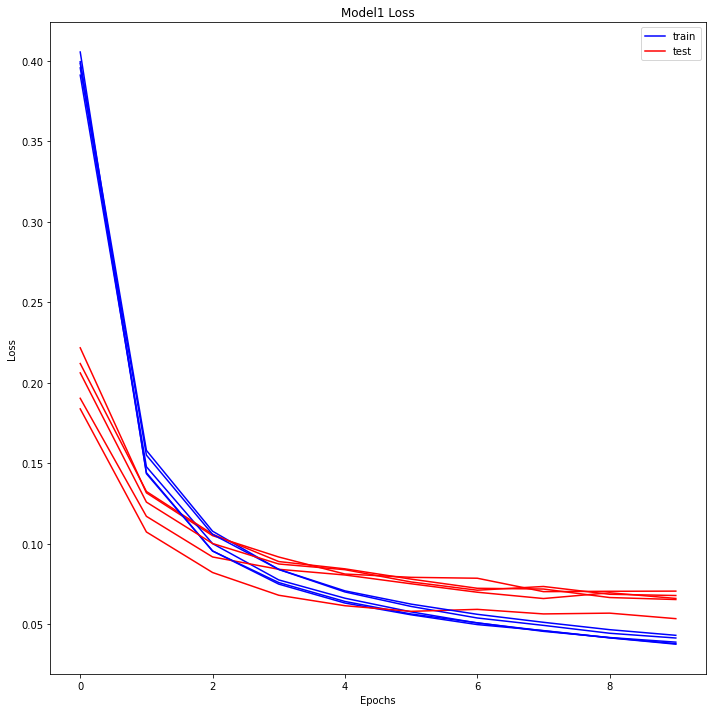

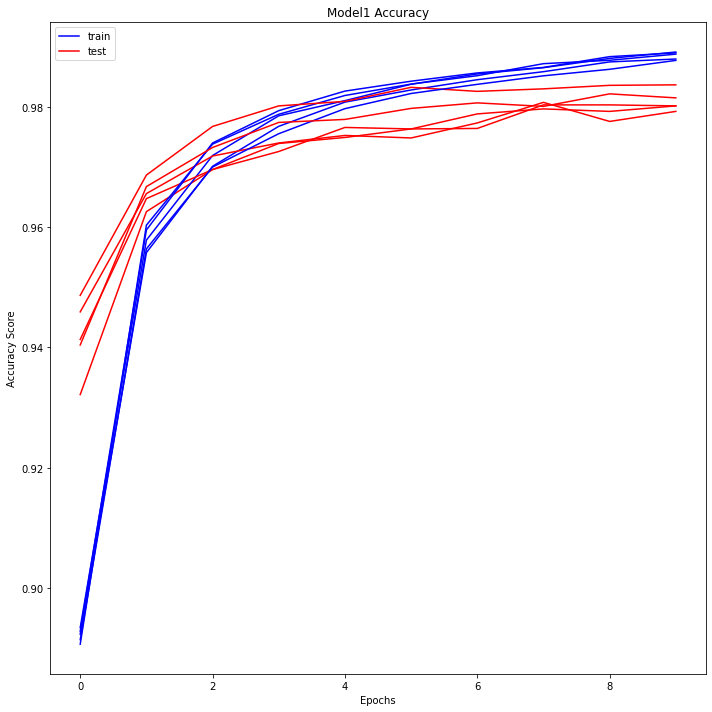

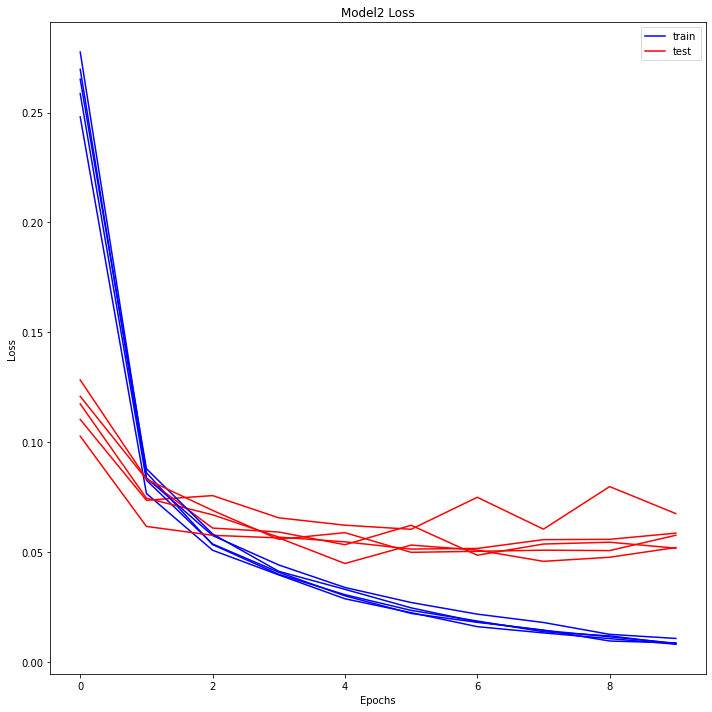

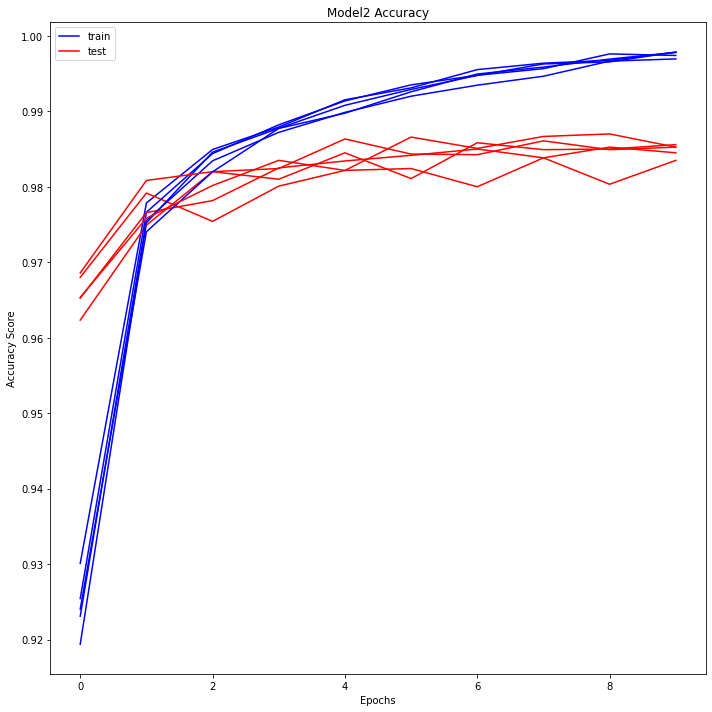

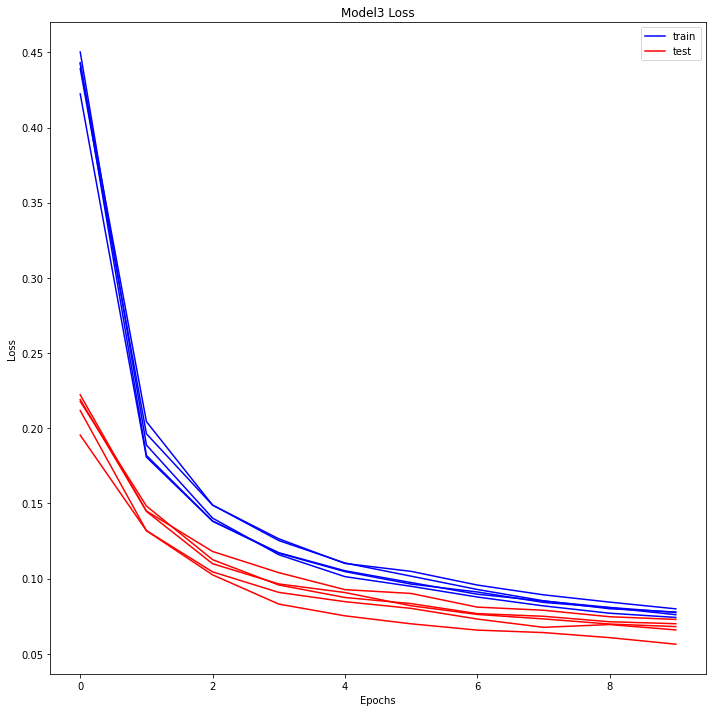

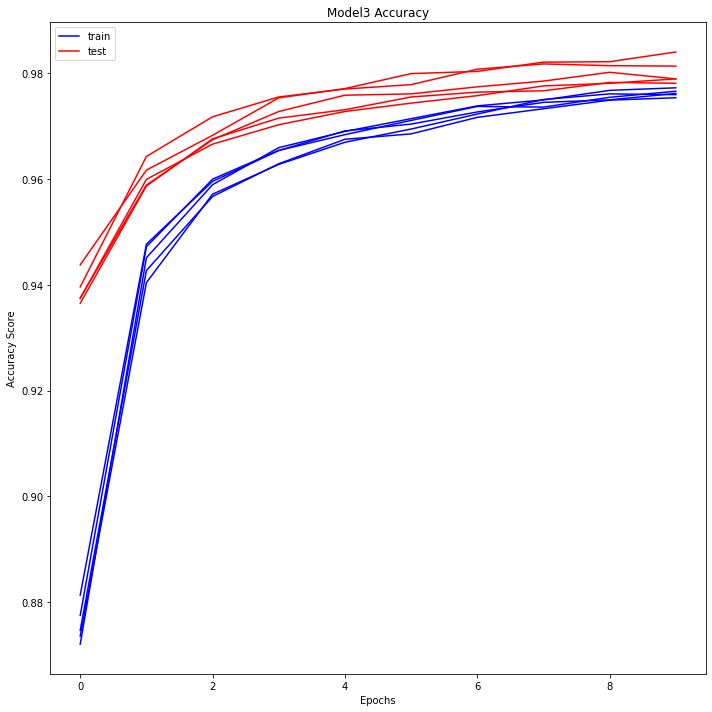

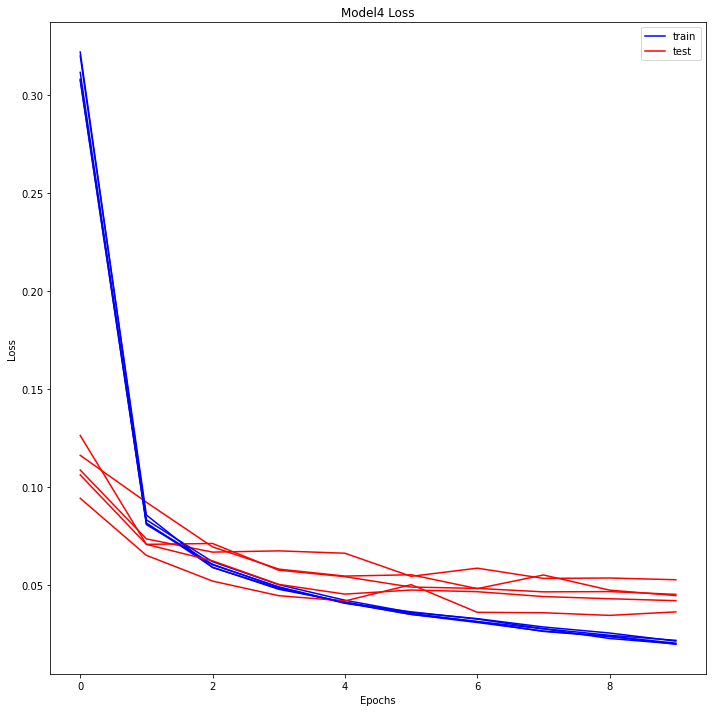

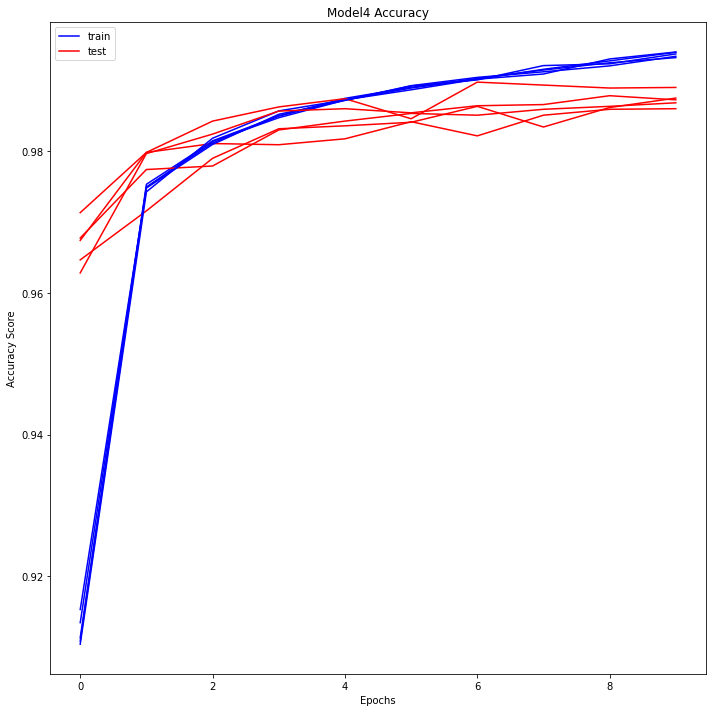

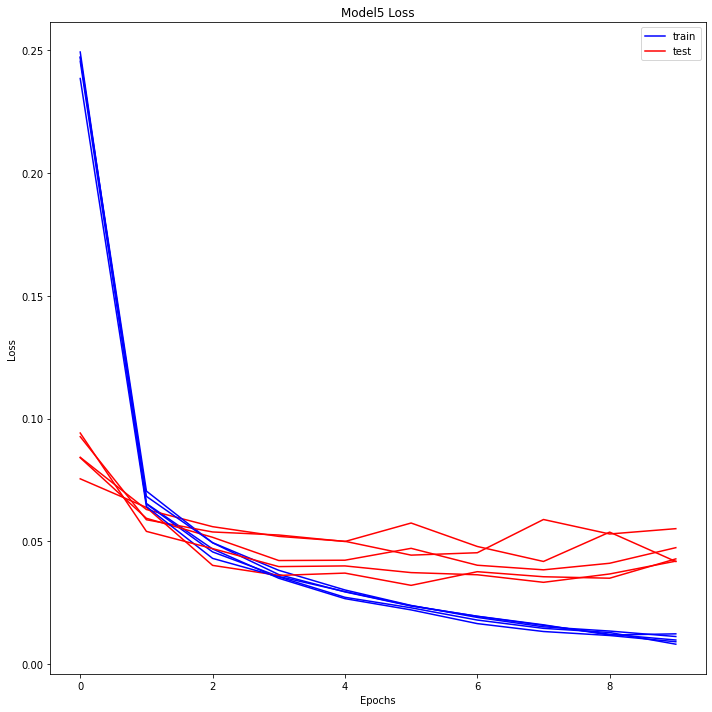

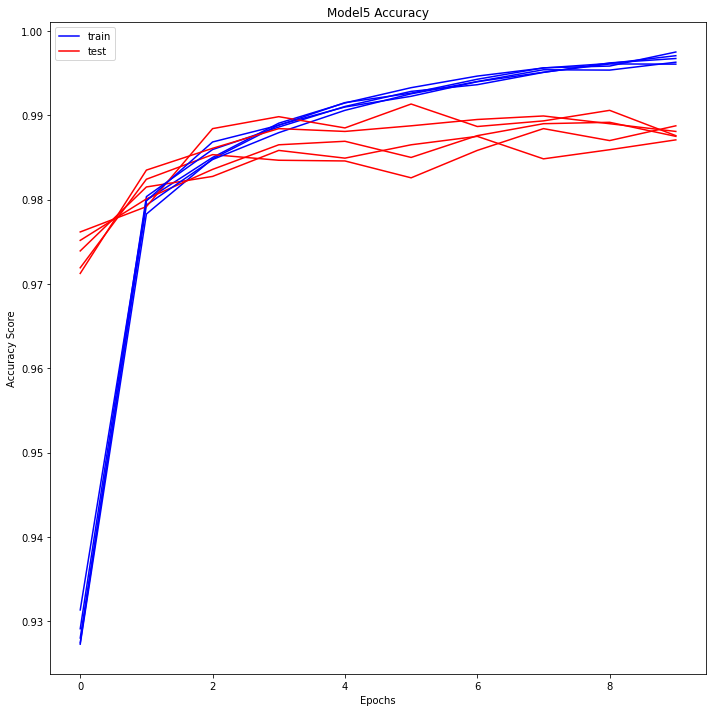

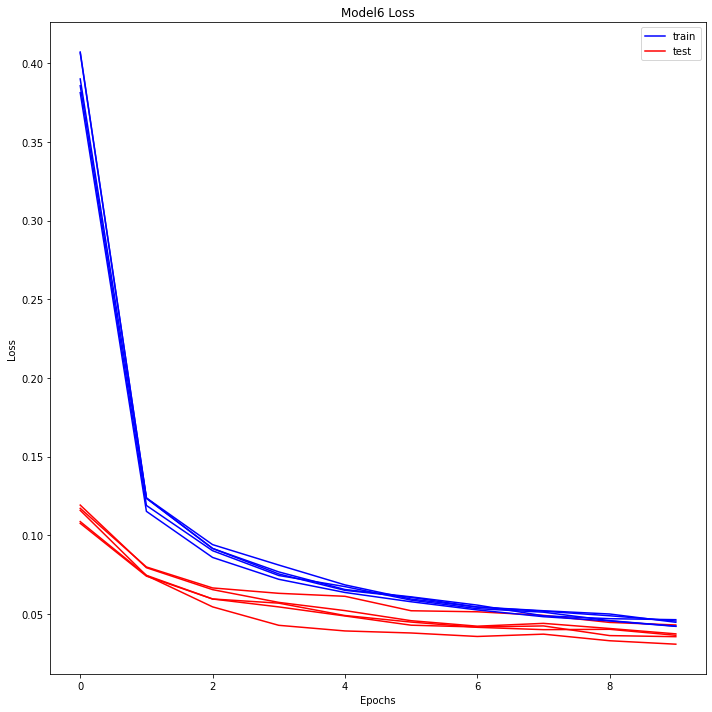

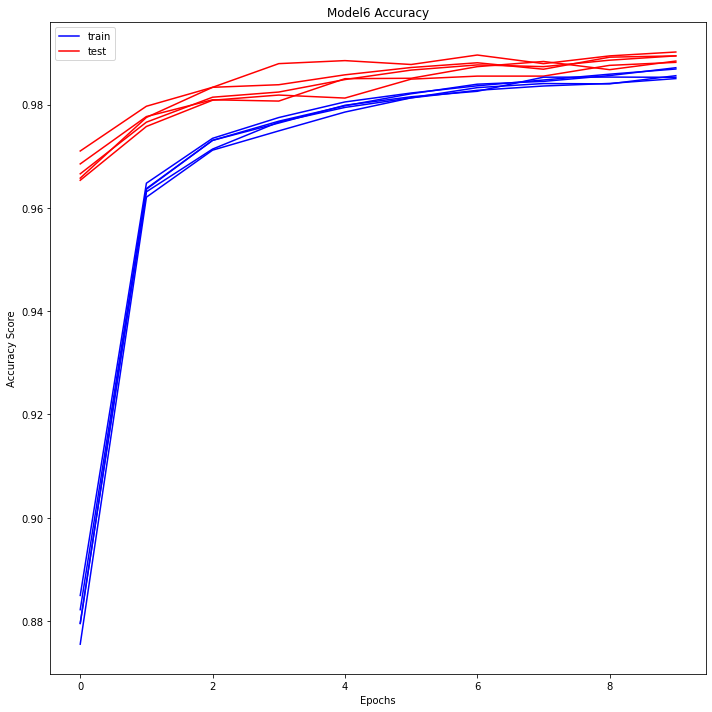

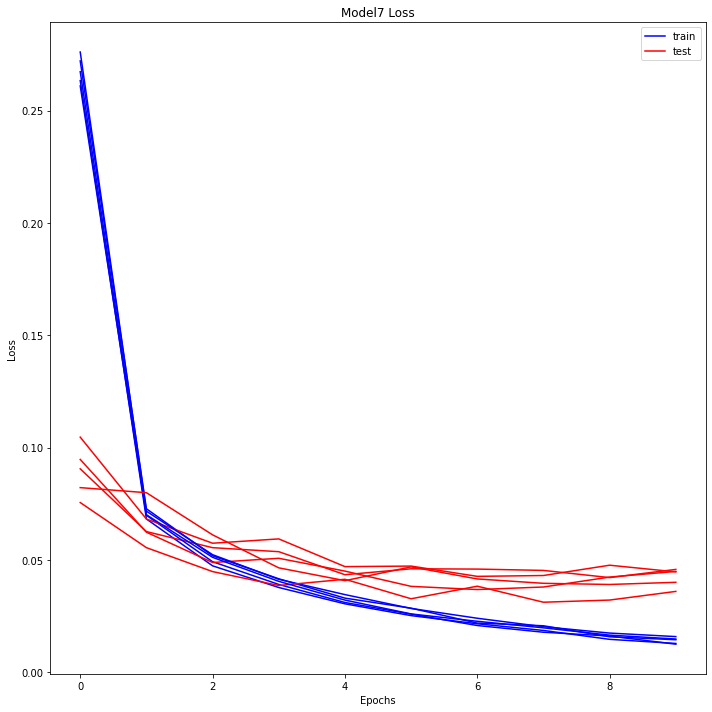

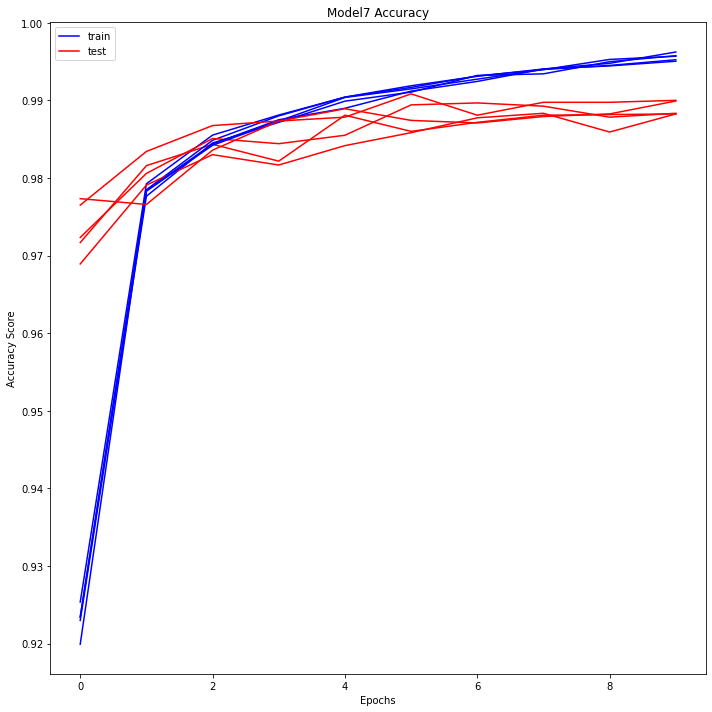

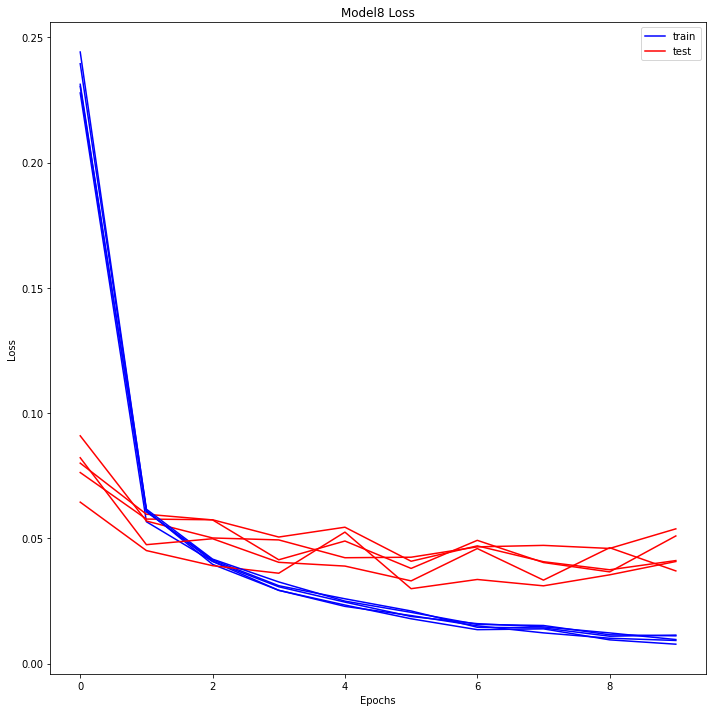

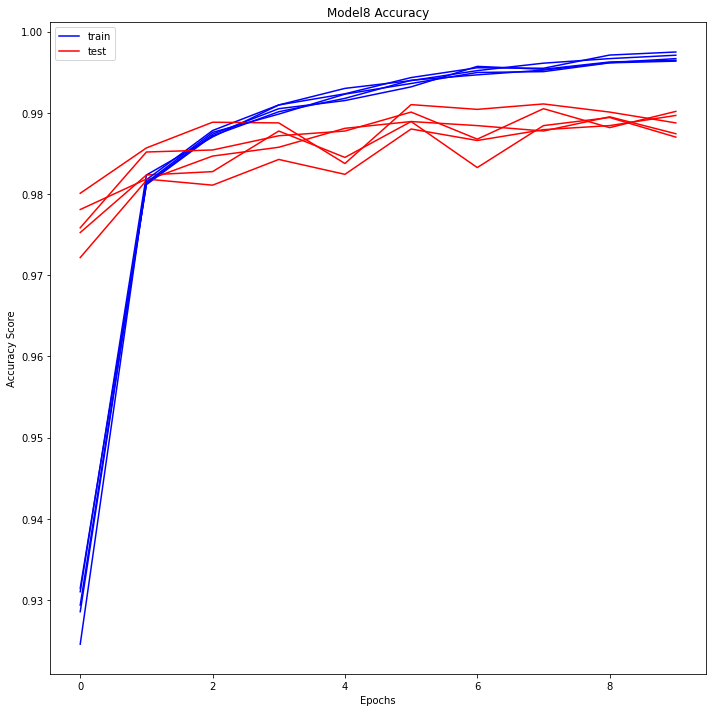

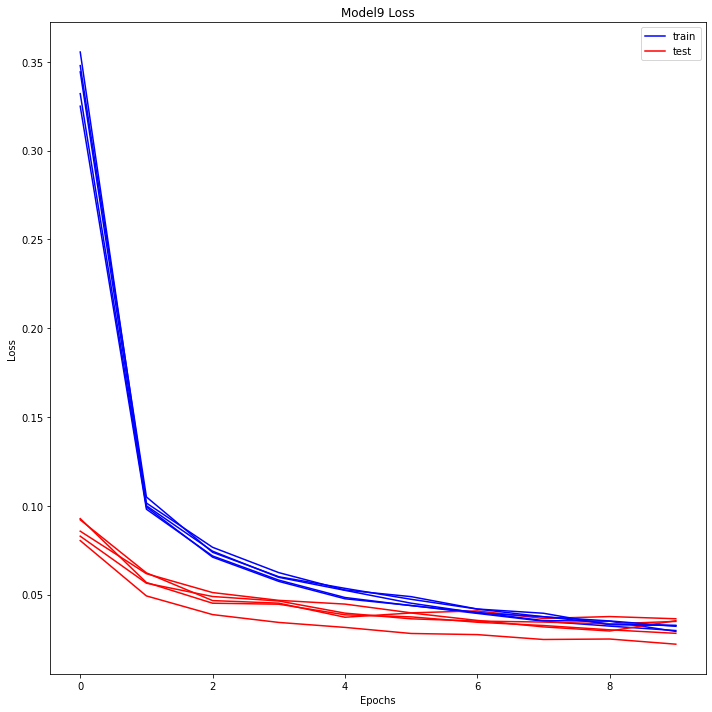

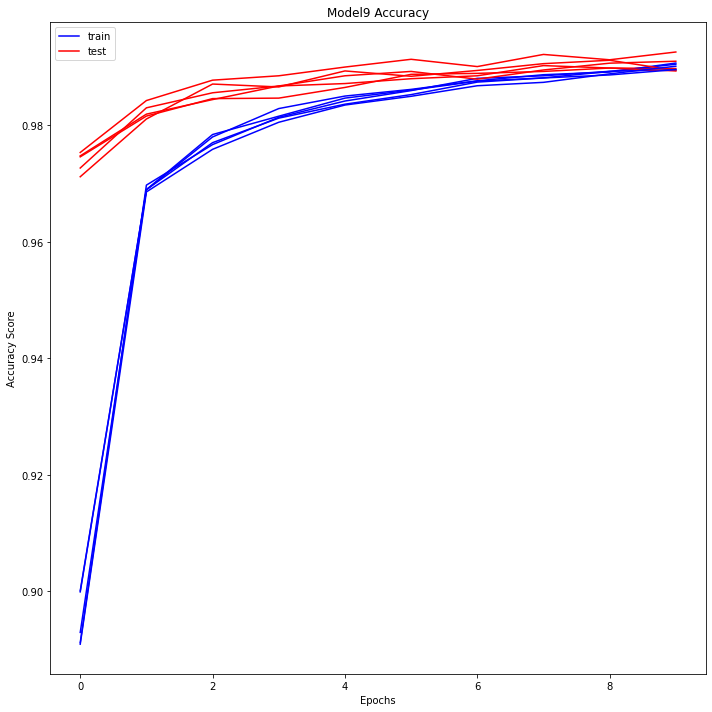

In [ ]:
i = 1
for history in model_histories:
  show_plots(history, i, 'cross')
  i += 1

Evaluating the final models with the real test data

In [ ]:
final_histories, final_accuracies = evaluate_final_models(create_models_array, x_train, y_train, x_test, y_test, n_folds, batch_size, num_of_epochs, verbose)

Accuracy: 98.15000295639038
Accuracy: 98.58999848365784
Accuracy: 98.18999767303467
Accuracy: 98.7500011920929
Accuracy: 98.87999892234802
Accuracy: 98.96000027656555
Accuracy: 99.22000169754028
Accuracy: 98.9799976348877
Accuracy: 99.32000041007996


Printing accuracies

In [ ]:
i = 1
for accuracy in final_accuracies:
  print('Model{} accuracy: {}'.format(i, accuracy*100))
  i += 1

Model1 accuracy: 98.15000295639038
Model2 accuracy: 98.58999848365784
Model3 accuracy: 98.18999767303467
Model4 accuracy: 98.7500011920929
Model5 accuracy: 98.87999892234802
Model6 accuracy: 98.96000027656555
Model7 accuracy: 99.22000169754028
Model8 accuracy: 98.9799976348877
Model9 accuracy: 99.32000041007996


Showing plots

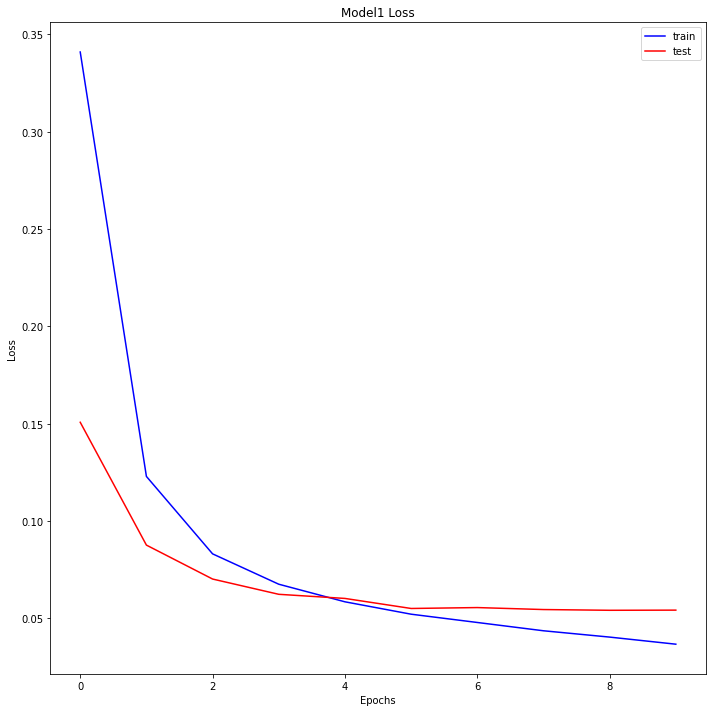

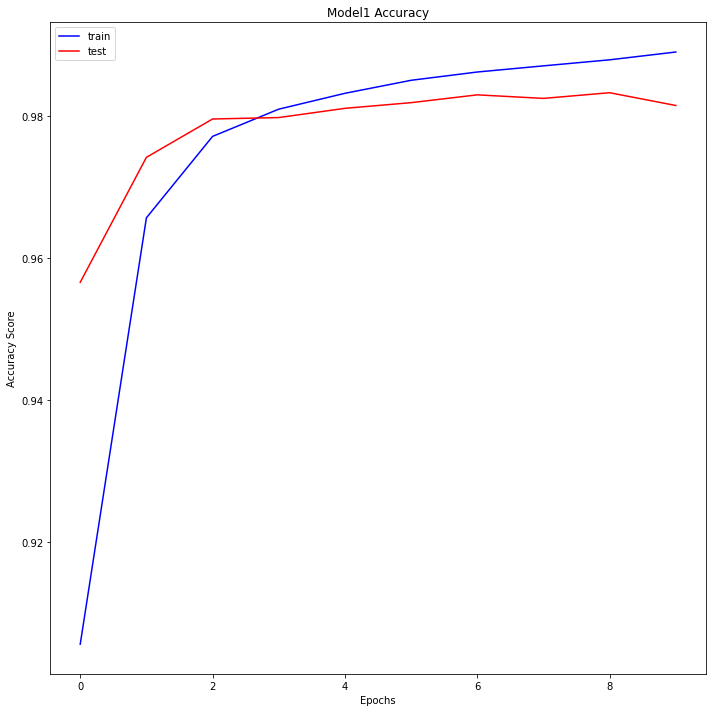

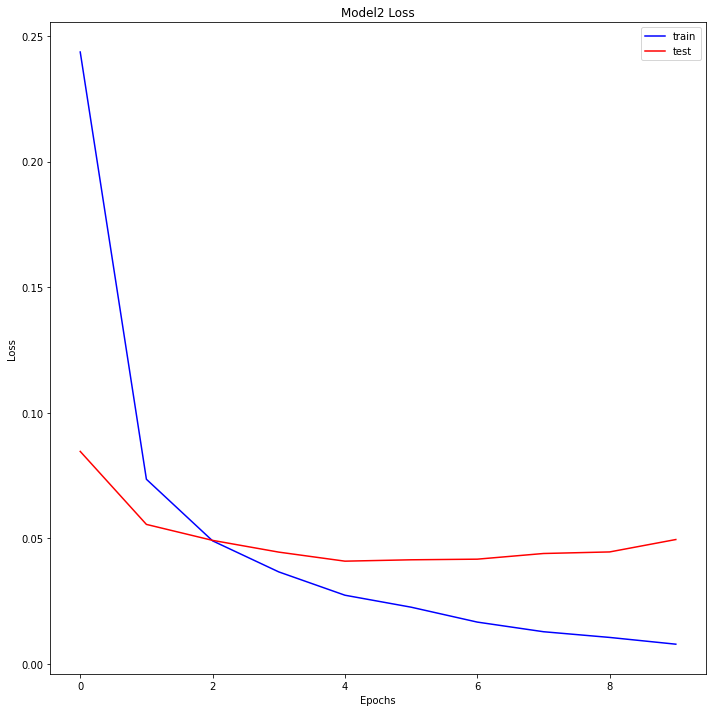

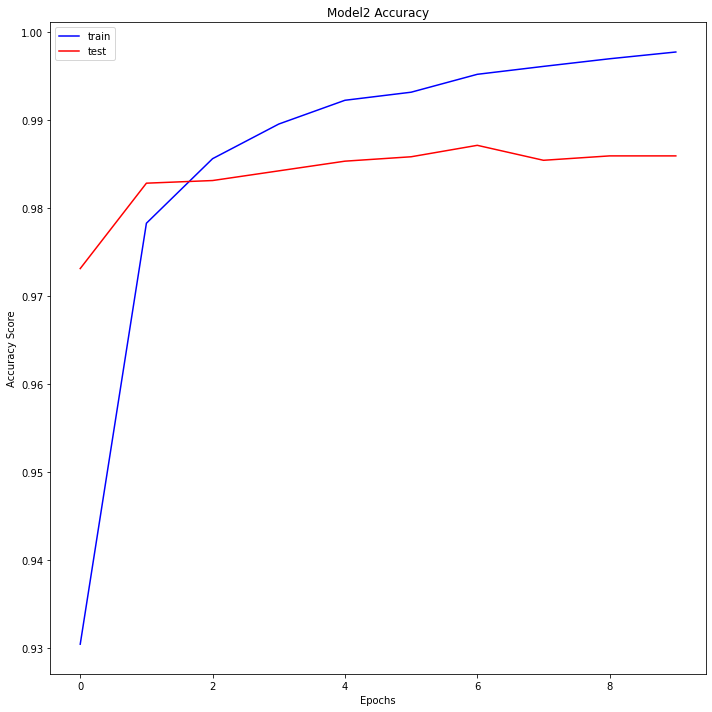

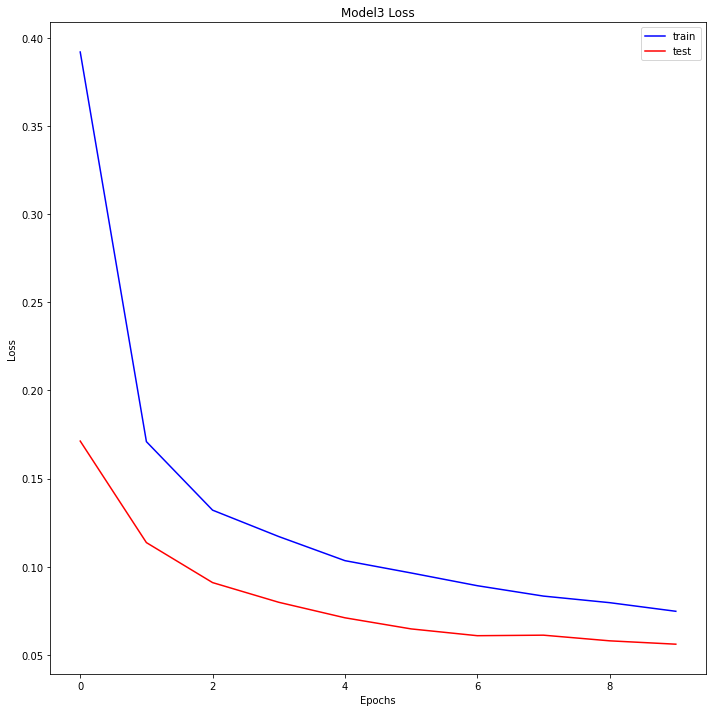

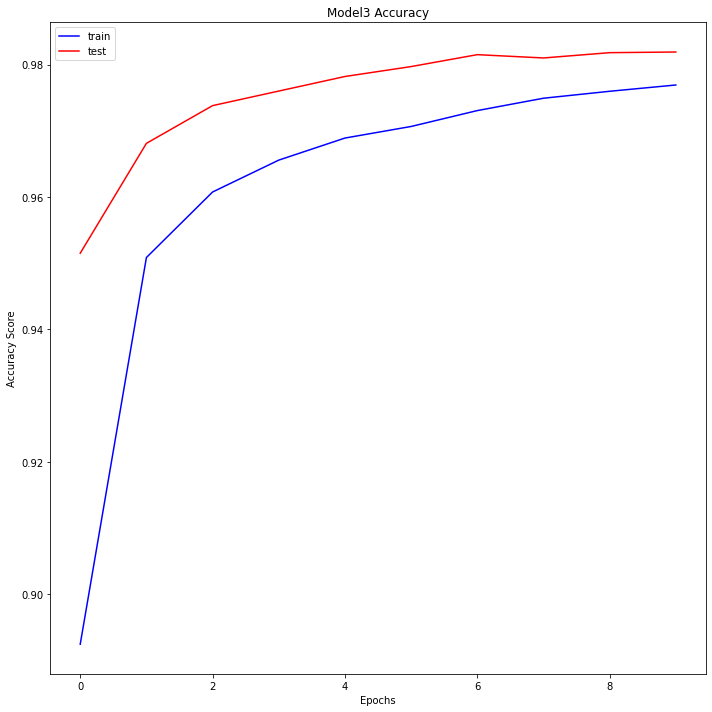

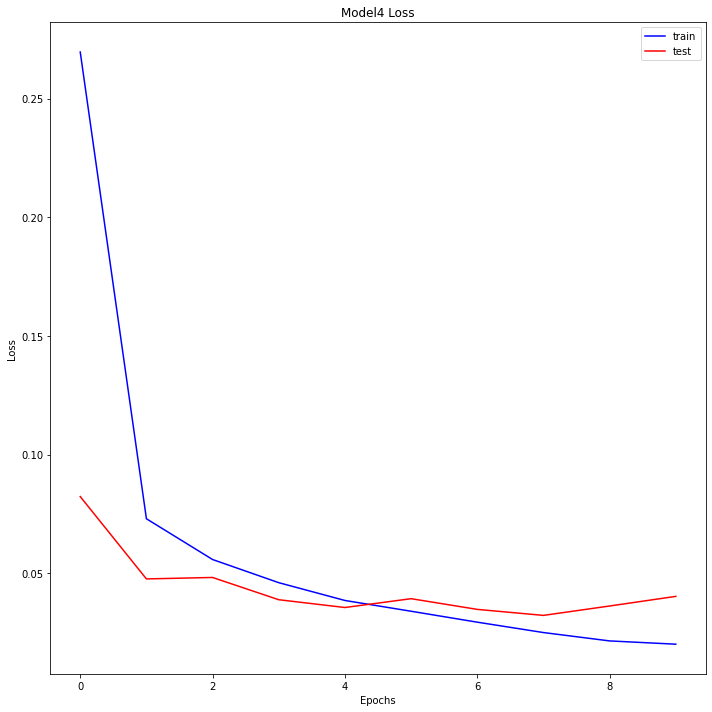

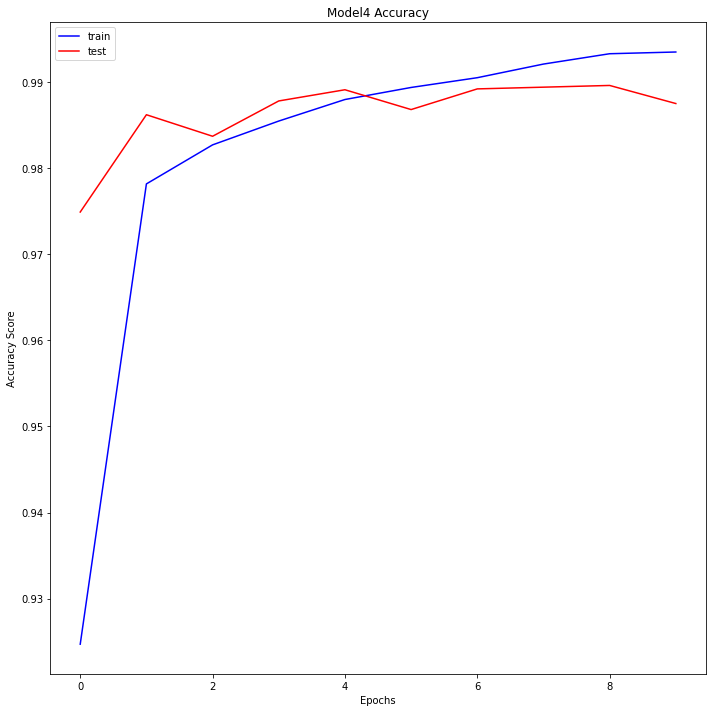

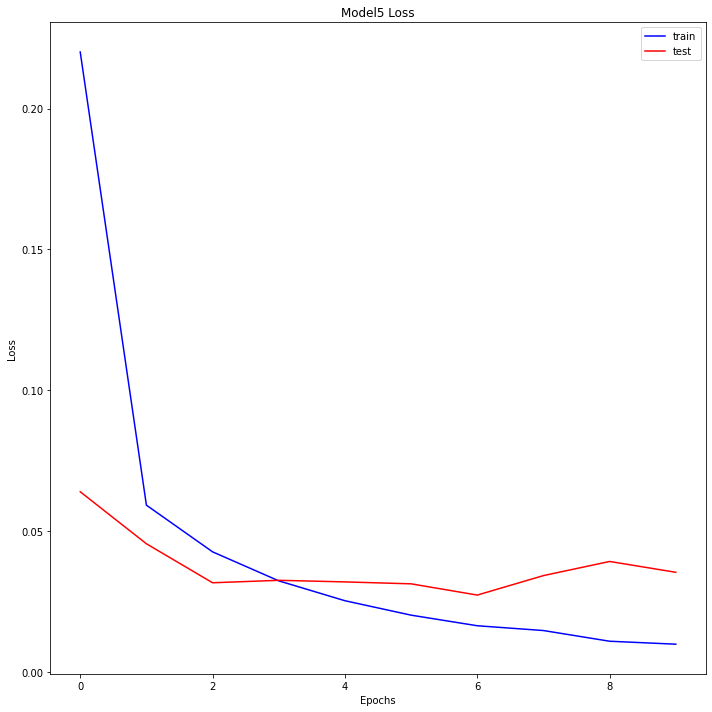

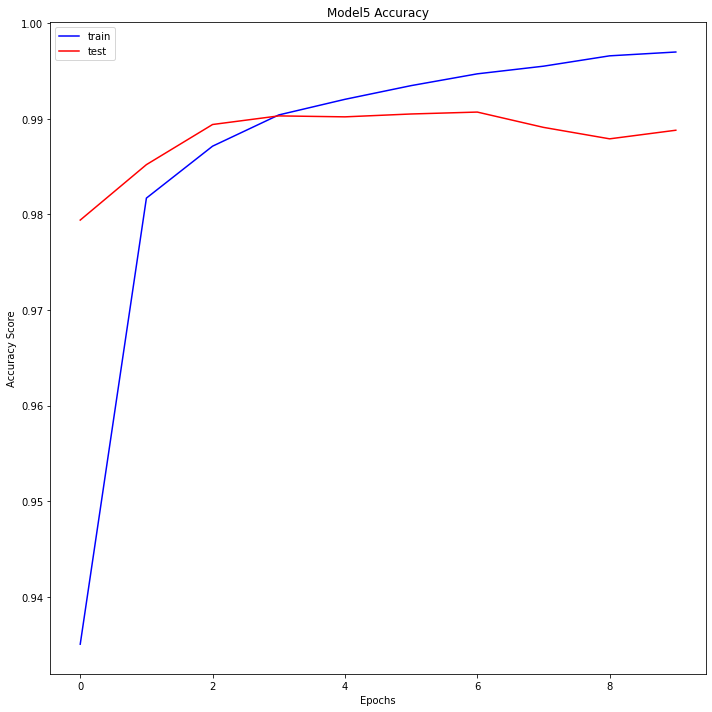

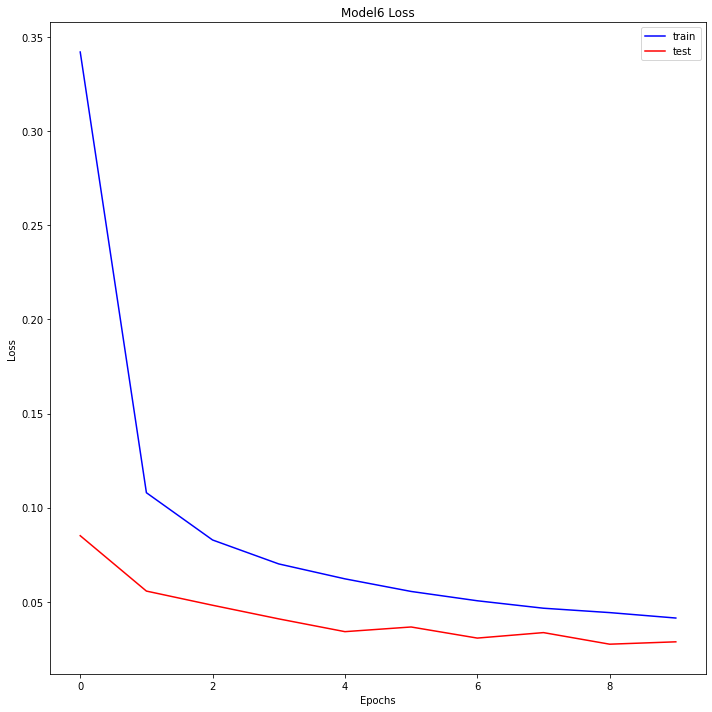

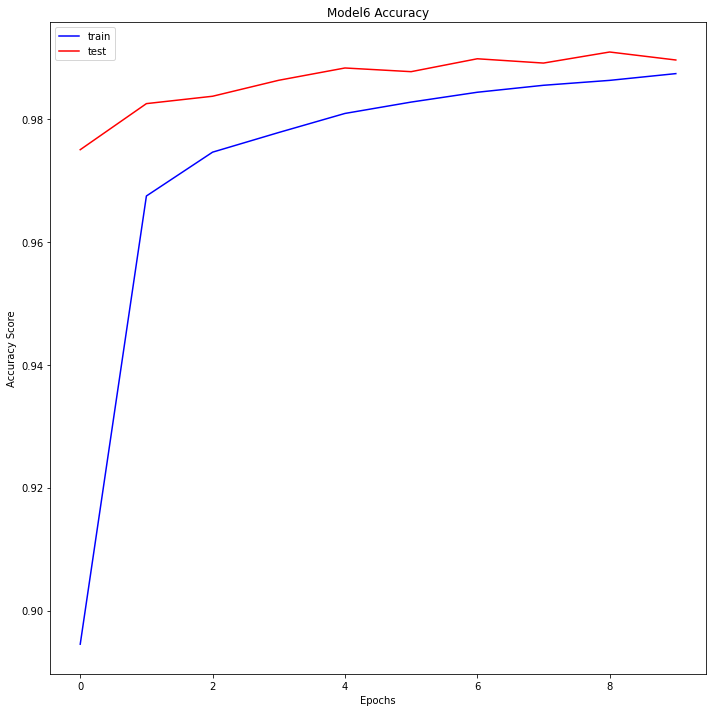

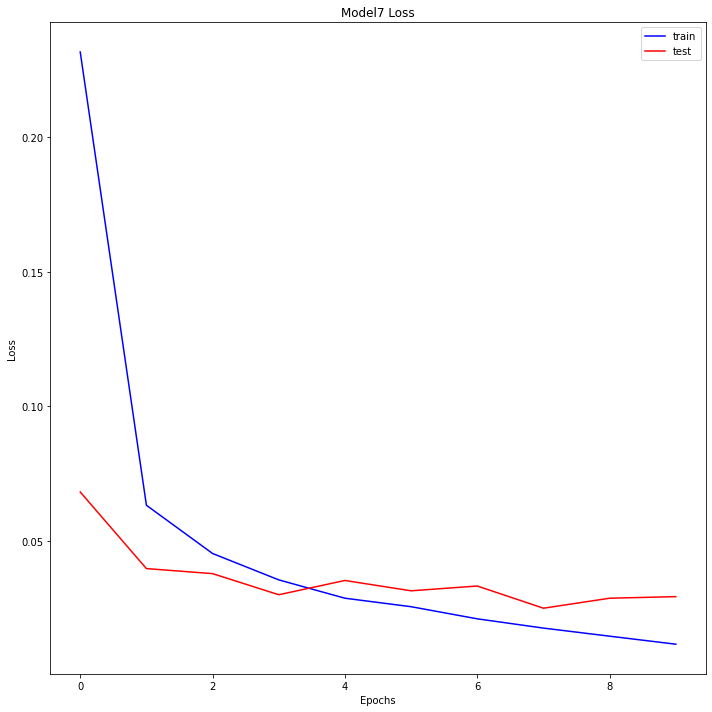

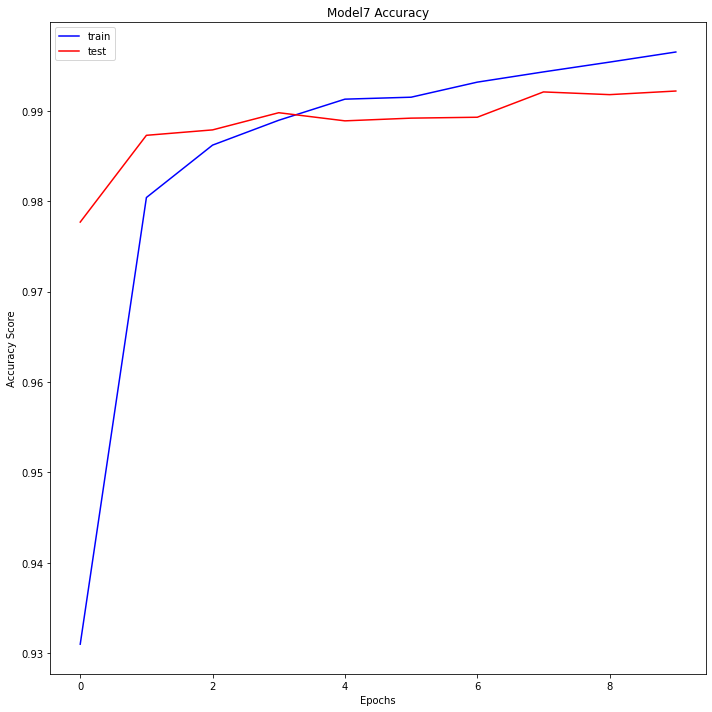

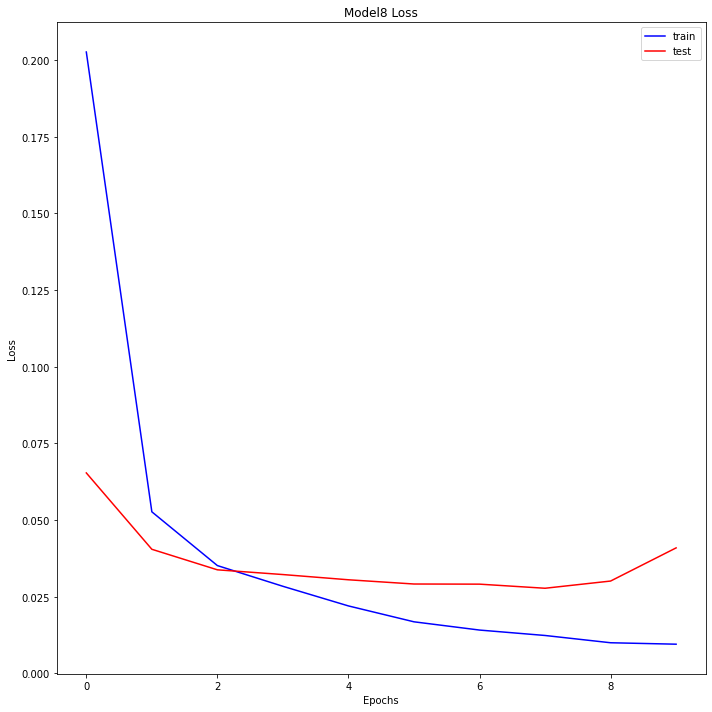

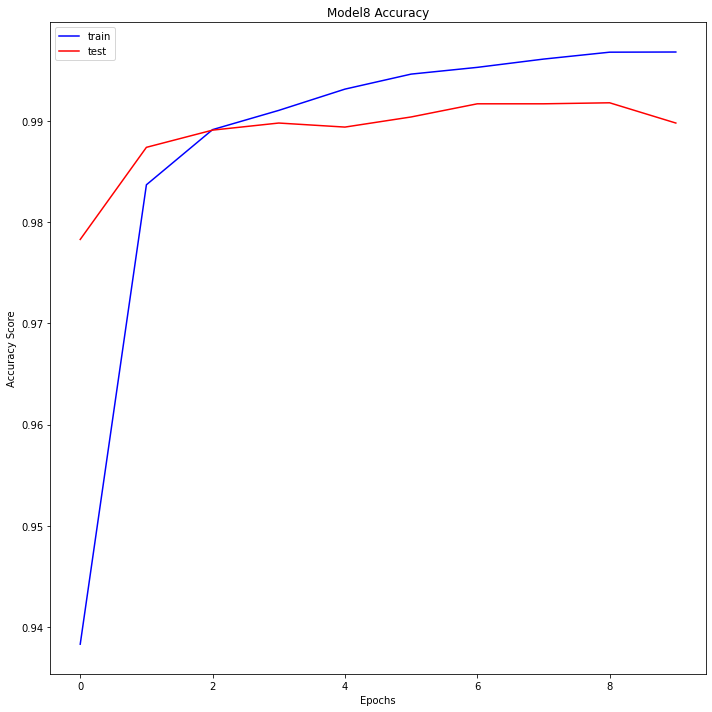

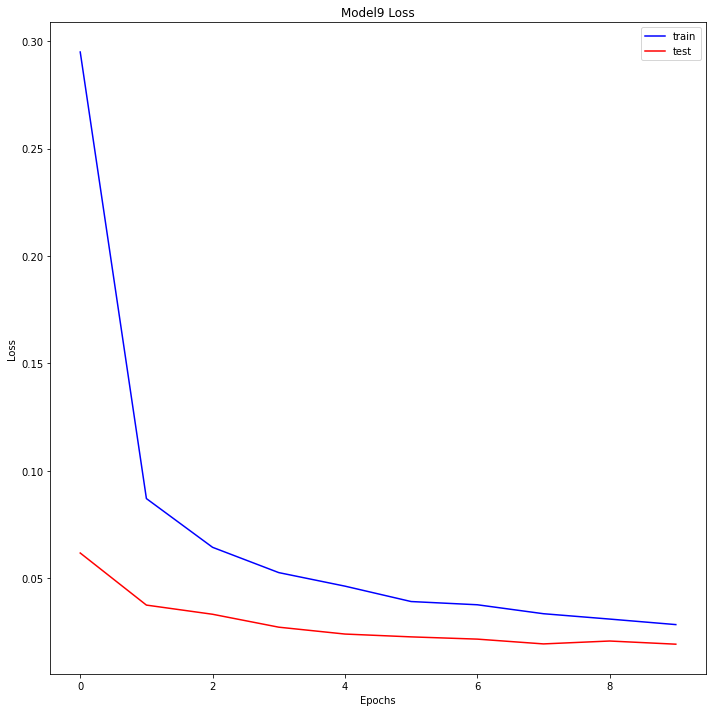

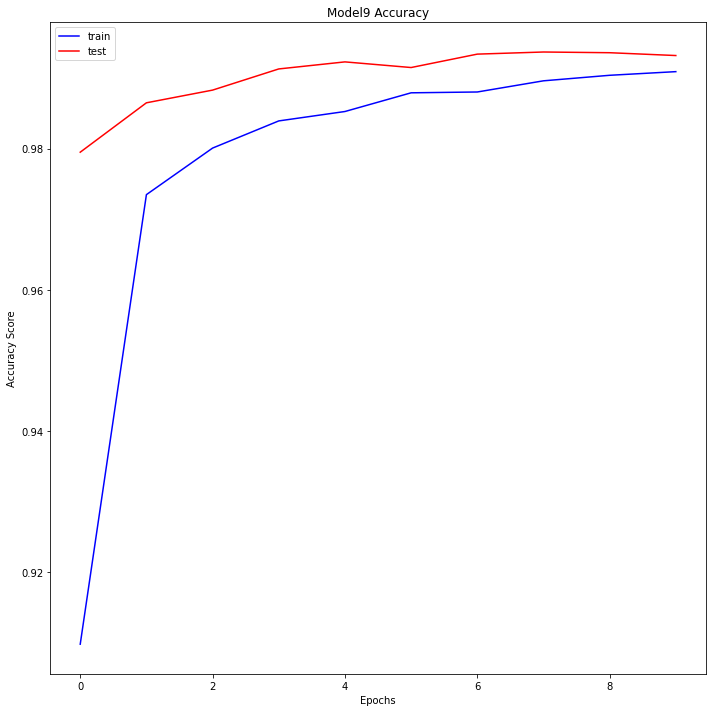

In [ ]:

i = 1
plt.rcParams['figure.figsize'] = (10,10)
for history in final_histories:
  plt.title('Model{} Loss'.format(i))
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='red', label='test')
  plt.xlabel('Epochs'),
  plt.ylabel('Loss'),
  plt.legend(loc='best')
  plt.tight_layout()
  plt.savefig('drive/MyDrive/university/machine_learning/optical_character_recognition/{}-loss{}.svg'.format('final', i), format='svg')
  plt.show()

  plt.title('Model{} Accuracy'.format(i))
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='red', label='test')
  plt.xlabel('Epochs'),
  plt.ylabel('Accuracy Score'),
  plt.legend(loc='best')
  plt.tight_layout()
  plt.savefig('drive/MyDrive/university/machine_learning/optical_character_recognition/{}-accuracy{}.svg'.format('final', i), format='svg')
  plt.show()
  i += 1